This notebook is for a pipeline of analyzing and visualizing a time-seires dataset. 

## Step 1: load package and preprocess functions

In [1]:
import pandas as pd
import numpy as np
import os
from wav2sleep.data.edf import load_edf_data
from wav2sleep.data.txt import parse_txt_annotations
from wav2sleep.data.utils import interpolate_index
from wav2sleep.data.xml import parse_xml_annotations
from wav2sleep.data.xml_parse_all import parse_all_annotations, annotate_waveform
from wav2sleep.data.rpoints import parse_process_rpoints_annotations
from wav2sleep.settings import *
from wav2sleep.config import *


In [2]:

import mne, pandas as pd, pathlib
### please modify path here
# annotation_path = '/scratch/besp/shared_data/shhs/polysomnography/annotations-events-nsrr/shhs1/shhs1-201935-nsrr.xml'
# edf_path = '/scratch/besp/shared_data/shhs/polysomnography/edfs/shhs1/shhs1-201935.edf'
# DATA_FOR_CHECK = 'shhs'
annotation_path = '/scratch/besp/shared_data/ccshs/polysomnography/annotations-events-nsrr/baseline/chat-baseline-300202-nsrr.xml'
edf_path = '/scratch/besp/shared_data/chat/polysomnography/edfs/baseline/chat-baseline-300202.edf'
# annotation_path = '/scratch/besp/shared_data/ccshs/polysomnography/annotations-events-nsrr/ccshs-trec-1800248-nsrr.xml'
# edf_path = '/scratch/besp/shared_data/ccshs/polysomnography/edfs/ccshs-trec-1800248.edf'
DATA_FOR_CHECK = 'chat'


###########################
edf = pathlib.Path(edf_path)
raw = mne.io.read_raw_edf(edf, preload=False, verbose="error")


hdr          = raw._raw_extras[0]              
rec_len_sec  = hdr['record_length']           
n_samps_list = hdr['n_samps']                  

rows = []
for idx, ch in enumerate(raw.info['chs']):
    sfreq = n_samps_list[idx] / rec_len_sec    
    rows.append(dict(channel   = ch['ch_name'],
                     sfreq_hz  = sfreq,
                     phys_unit = ch.get('unit', '—'),
                     lowpass   = ch.get('lowpass',  '—'),
                     highpass  = ch.get('highpass', '—')))

df = pd.DataFrame(rows)#.sort_values("sfreq_hz", ascending=False)
print(df)          

        channel        sfreq_hz  phys_unit lowpass highpass
0        REF X1  [200.0, 200.0]        107       —        —
1            E1  [200.0, 200.0]        107       —        —
2            E2  [200.0, 200.0]        107       —        —
3            F3  [200.0, 200.0]        107       —        —
4            F4  [200.0, 200.0]        107       —        —
5            C3  [200.0, 200.0]        107       —        —
6            C4  [200.0, 200.0]        107       —        —
7            T3  [200.0, 200.0]        107       —        —
8            T4  [200.0, 200.0]        107       —        —
9            O1  [200.0, 200.0]        107       —        —
10           O2  [200.0, 200.0]        107       —        —
11           M1  [200.0, 200.0]        107       —        —
12           M2  [200.0, 200.0]        107       —        —
13        Lchin  [200.0, 200.0]        107       —        —
14        Rchin  [200.0, 200.0]        107       —        —
15        Cchin  [200.0, 200.0]        1

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def format_overlapping_events(events_df, event_cols):
    # Create a new column for overlapping events
    events_df['Multiple Events'] = None

    # For each row, check for overlapping events
    for idx in events_df.index:
        row_events = []
        for col in event_cols:
            if pd.notna(events_df.loc[idx, col]):
                row_events.append(events_df.loc[idx, col])
        
        # If multiple events, combine them and set original columns to NaN
        if len(row_events) > 1:
            events_df.loc[idx, 'Multiple Events'] = ' and '.join(row_events)
            for col in event_cols:
                events_df.loc[idx, col] = None

    # Add overlapping_events to event_cols
    event_cols.append('Multiple Events')

    return events_df, event_cols

def get_colormap(events_df, event_cols):
    custom_colors = [
        '#800000',  # Maroon (Dark Red)
        '#457B9D',  # Steel Blue
        '#556B2F',  # Dark Olive Green
        '#533100',  # Brown
        '#581845',  # Dark Purple
        '#2F4F4F',  # Dark Slate Gray'
        '#CD5C5C',  # Indian Red (a bit lighter, but distinct)
        '#DAA520',  # Goldenrod
        '#40E0D0',  # Turquoise
    ]
    all_events = []
    for col in event_cols:
        all_events.extend(events_df[col].dropna().unique())
    unique_events = np.unique(all_events)
    event_colors = dict(zip(unique_events, custom_colors[:len(unique_events)]))
    return event_colors
def plot_channels_annotations_sleep_stage(df_input, channel_cols, stage_col = 'Sleep Stage', stage_labels=None):
    """
    Plot multiple channels of sensor data with highlighted event intervals. NOTE: sleep stage should be bfilled to propagate 30-sec epoch stage to all timepoints in the interval

    Parameters:
    -----------
    df_input : pandas.DataFrame
        DataFrame containing the data with channel and channel_events annotation columns
    channel_cols : list
        List of channel column names to plot. Assumes annotation columns with _events exists for some channels.
    stage_col : str 
        Name of sleep stage column
    """

    n_channels = len(channel_cols)
    fig, axes = plt.subplots(n_channels, 1, figsize=(18, 5*n_channels), sharex=True)

    # First plot the event annotation boxes that will span all subplots
    event_cols = [col for col in df_input.columns if col.endswith('_events')]
    # Create a copy of df with just event columns
    events_df = df_input[event_cols].copy()
    # Create copy of df, might manipulate 
    df = df_input.copy()

    # Format overlapping events in a new column 'Multiple Events'
    events_df, event_cols = format_overlapping_events(events_df, event_cols)

    # Create a color map for all unique events across all columns
    event_colors = get_colormap(events_df, event_cols)

    # --- Plot annotation events
    for event_col in event_cols:
        # Get unique events in this window
        events = events_df[event_col].dropna().unique()
        for event in events:
            # Find start and end times for each event
            event_mask = events_df[event_col] == event
            event_starts = events_df.index[event_mask & ~event_mask.shift(1).fillna(False)]
            event_ends = events_df.index[event_mask & ~event_mask.shift(-1).fillna(False)]
            
            # Add transparent box for each event occurrence spanning all subplots
            for start_time, end_time in zip(event_starts, event_ends):
                # Add to first subplot to avoid duplicate legend entries+_
                span = axes[0].axvspan(start_time, end_time, color=event_colors[event], alpha=0.3, label=f'{event_col}: {event}')
                # Add same span to all other subplots without labels
                for ax in axes[1:]:
                    ax.axvspan(start_time, end_time, color=event_colors[event], alpha=0.3)

    # --- Plot each channel in its own subplot
    for idx, (channel, ax) in enumerate(zip(channel_cols, axes)):
        if channel in df.columns:
            # Plot non-NaN values only
            valid_data = df[channel].dropna()
            if not valid_data.empty:
                ax.plot(valid_data.index, valid_data.values, linewidth=0.5)
                ax.set_ylabel(channel)
                # Add grid
                #ax.grid(True, alpha=0.3)
                
                ax.set_xlabel('Time (seconds)')
                ax.tick_params(axis='x', labelbottom=True)

    # --- get handles and labels ready to plot legend of annotation events
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        # Get unique handles and labels while preserving order
        unique_labels = []
        unique_handles = []
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels.append(l)
                unique_handles.append(h)

    # --- Sleep Stages
    # Optional: define readable labels
    if stage_labels is None:
        # Get unique sleep stages
        unique_stages = df[stage_col].dropna().unique()
        stage_labels = {int(k): 'Stage' + str(int(k)) for k in unique_stages}
    else:
        # map sleep stage numbers to labels 
        df[stage_col] = df[stage_col].map(stage_labels)
        # Get unique sleep stages
        unique_stages = df[stage_col].dropna().unique()
    # Overlay sleep stage bar at bottom of every axis (use height just below lowest frequency)
    stage_band_y_axes = {}
    band_height_axes = {}
    for i, ax in enumerate(axes):
        ymin, ymax = ax.get_ylim()
        stage_band_y_axes[i] = ymin - ((ymax-ymin) * 0.05)  # slight offset below
        band_height_axes[i] = ((ymax-ymin) * 0.05)
    # Custom color map
    color_map = ListedColormap(plt.cm.tab10.colors[:len(unique_stages)])
    stage_to_idx = {stage: idx for idx, stage in enumerate(unique_stages)} # map stage number to index number to use to access color_map
    # Construct colored rectangles (one per time bin)
    for j, (channel, ax) in enumerate(zip(channel_cols, axes)):
        df_subset = df[[channel, stage_col]].dropna()
        stage_values = df_subset[stage_col].values
        time_values = df_subset.index.values
        # Detect stage changes
        changes = np.where(stage_values[:-1] != stage_values[1:])[0] + 1 # indices where stage changes
        segments = np.split(np.arange(len(stage_values)), changes) # split into segments of continuous sleep stages
        # Draw one rectangle per segment
        for seg in segments:
            stage = stage_values[seg[0]]
            ax.add_patch(plt.Rectangle(
                (time_values[seg[0]], stage_band_y_axes[j]), # anchor
                time_values[seg[-1]] - time_values[seg[0]], # width
                band_height_axes[j], # height
                color=color_map(stage_to_idx[stage]),
                linewidth=0
            ))

    # --- Legend for sleep stages
    legend_patches = [plt.Line2D([0], [0], color=color_map(stage_to_idx[stage]), lw=6)
                      for stage in unique_stages] # dummy lines for legend
    #legend_labels = [stage_labels[int(stage)] for stage in unique_stages]
    legend_labels = unique_stages
    for j, ax in enumerate(axes):
        ymin, ymax = ax.get_ylim()
        legend1 = ax.legend(legend_patches, legend_labels, loc='center left', bbox_to_anchor=(1.0, 0.5),
                title="Sleep Stage", fontsize='small')
        ax.add_artist(legend1) # add first legend as artist
        ax.set_ylim(stage_band_y_axes[j], ymax)
    
    # --- Legend for annotation events
    if handles:
        for ax in axes:
            ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    return fig

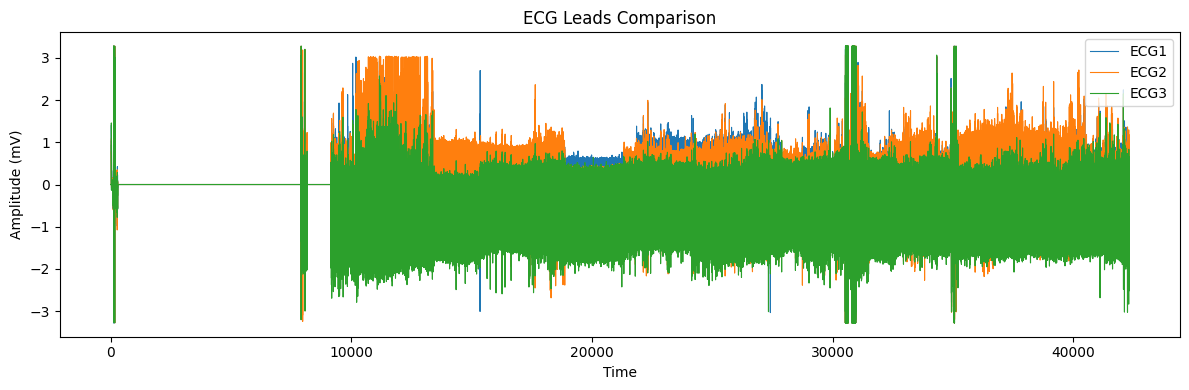

In [8]:
import matplotlib.pyplot as plt            
plt.style.use('default')                  
df = load_edf_data(edf_path, columns=EDF_COLS + ['ECG1', 'ECG2', 'ECG3'], raise_on_missing=False)




In [9]:
print(df.columns)

Index(['ECG', 'ABD', 'THX', 'AF', 'NP', 'SN', 'EOG_L', 'EOG_R', 'EMG_RChin',
       'EMG_LChin', 'EMG_CChin', 'EEG_C3', 'EEG_C4', 'EEG_A1', 'EEG_A2',
       'EEG_O1', 'EEG_O2', 'EEG_F3', 'EEG_F4', 'ECG1', 'ECG2', 'ECG3'],
      dtype='object')


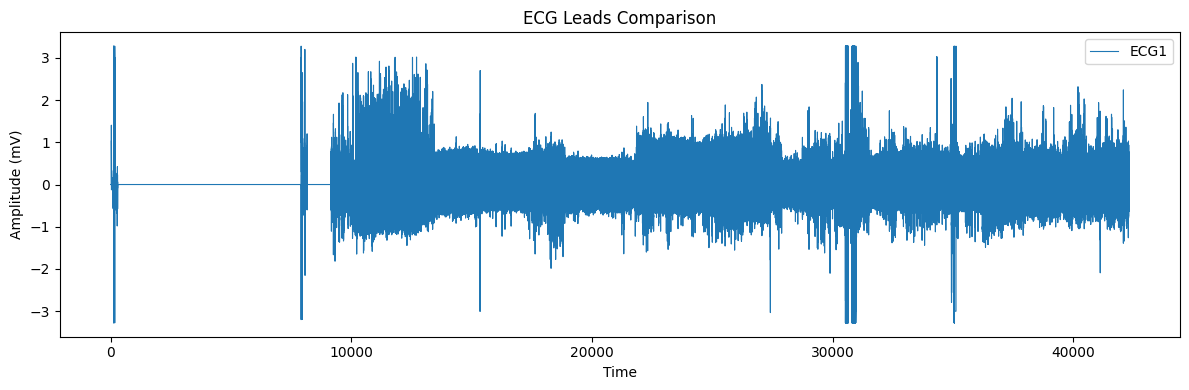

In [10]:

ax = df[['ECG1']].plot(
    figsize=(12, 4),       
    linewidth=0.8,         
)

ax.set_xlabel('Time')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('ECG Leads Comparison')
ax.legend(loc='upper right')               
plt.tight_layout()                         
plt.show()

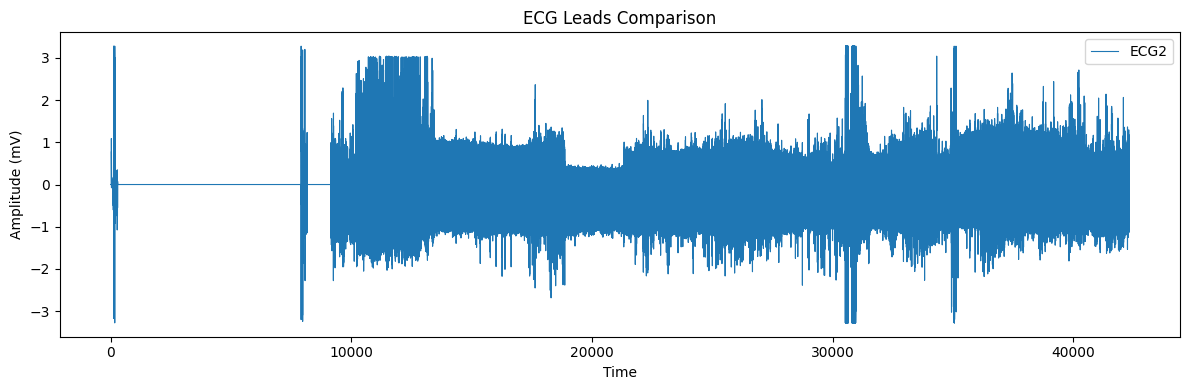

In [11]:

ax = df[['ECG2']].plot(
    figsize=(12, 4),       
    linewidth=0.8,         
)

ax.set_xlabel('Time')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('ECG Leads Comparison')
ax.legend(loc='upper right')               
plt.tight_layout()                         
plt.show()

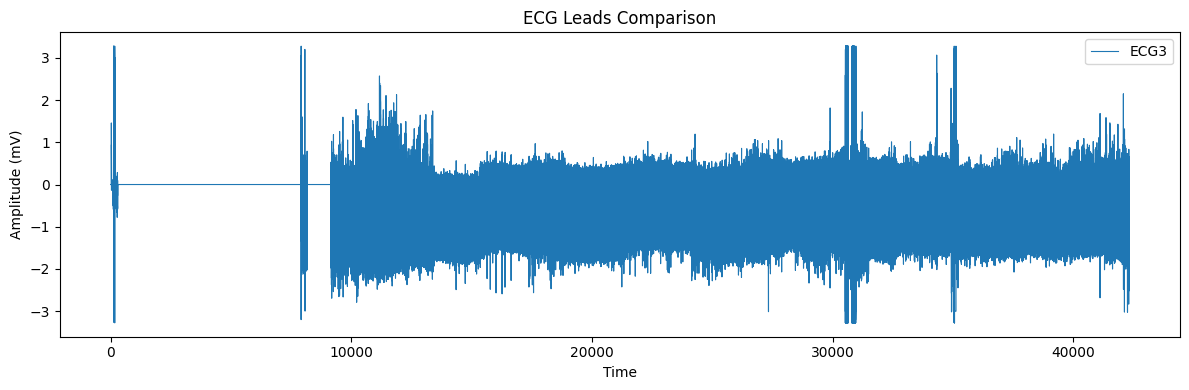

In [12]:

ax = df[['ECG3']].plot(
    figsize=(12, 4),       
    linewidth=0.8,         
)

ax.set_xlabel('Time')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('ECG Leads Comparison')
ax.legend(loc='upper right')               
plt.tight_layout()                         
plt.show()